## V7_Infra_Score_LightGBM_kfold5

In [1]:
import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# path 설정
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("")))))
print(sys.path[-1])

d:\base\boostcamp\apart\level2-competitiveds-recsys-06


In [2]:
raw_path: str = "../../../data/raw"
processed_path: str = "../../../data/processed"
submission_path: str = "../../../data/submission"

In [4]:
v7: pd.DataFrame = pd.read_csv(os.path.join(processed_path,"v7_infra_score.csv"))

### Arima_Deposit_Index 추가

### 컬럼 정리

In [5]:
v7_contract_type = pd.get_dummies(v7, columns=['contract_type'], prefix='contract')
v7_contract_type.columns

Index(['index', 'area_m2', 'contract_year_month', 'contract_day', 'floor',
       'built_year', 'latitude', 'longitude', 'age', 'deposit', '_type',
       'apt_idx', 'area', 'area_price', 'area_m2_price', 'grid_id',
       'nearest_subway_distance', 'nearest_subway_idx',
       'num_subway_within_1km', 'category_interchange_within_1km',
       'num_subway_within_500m', 'category_interchange_within_500m',
       'nearest_elementary_school_distance',
       'nearest_elementary_school_within_1km',
       'has_elementary_school_within_1km', 'nearest_middle_school_distance',
       'nearest_middle_school_within_1km', 'has_middle_school_within_1km',
       'nearest_high_school_distance', 'nearest_high_school_within_1km',
       'has_high_school_within_1km', 'nearest_park_distance',
       'nearest_park_within_500.0m', 'has_park_within_500.0m',
       'apt_deposit_rank', 'apt_area_deposit_rank', 'original_index',
       'recent_deposit', 'interest_rate', 'diff_interest_rate',
       'arima_de

In [6]:
# columns_to_drop = ['contract_type', 'contract_2','area_m2_price', 'area_price', 'date', 'contract_ymd', 'original_index', 'interest_rate', 'diff_interest_rate']
# df = v4_arima_contract_type.drop(columns=columns_to_drop, errors='ignore')

columns = ['index', 'area_m2', 'floor', 'age', 'latitude', 'longitude', 'apt_idx','nearest_subway_distance', 'category_interchange_within_1km',
           'deposit', '_type', 'grid_id', 'apt_deposit_rank', 'apt_area_deposit_rank', 'recent_deposit', 
           'contract_year_month', 'contract_0', 'contract_1', 'infra_score']
df = v7_contract_type.filter(items=columns)

temp_train_df = df[df["_type"]=='train']
test_df = df[df["_type"]=='test']

## K-Fold CV(k=5) 적용 LightGBM

In [7]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 학습에 사용할 특징 열
feature_columns = [col for col in temp_train_df.columns if col not in ['deposit', '_type', 'index']]

# 학습 데이터 준비
X = temp_train_df[feature_columns]
y = temp_train_df['deposit']

# 결측치 대체
X['recent_deposit'] = X['recent_deposit'].fillna(39000)

# LightGBM 파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
}

# 콜백 함수 정의
def print_evaluation(period=10):
    def callback(env):
        if (env.iteration + 1) % period == 0:
            train_mae = env.evaluation_result_list[0][2]
            val_mae = env.evaluation_result_list[1][2]
            print(f"[{env.iteration + 1}] Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")
    return callback

# 5-fold 교차 검증 설정
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# 각 폴드의 예측 결과를 저장할 리스트
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(test_df))

# 교차 검증 수행
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    
    model = lgb.train(
        params, 
        dtrain, 
        num_boost_round=1000, 
        valid_sets=[dtrain, dval], 
        callbacks=[print_evaluation(period=100)]
    )
    
    # 검증 세트에 대한 예측
    oof_predictions[val_idx] = model.predict(X_val)
    
    # 테스트 세트에 대한 예측
    test_predictions += model.predict(test_df[feature_columns]) / n_folds

# 전체 검증 세트에 대한 MAE 계산
oof_mae = mean_absolute_error(y, oof_predictions)
print(f"\nOverall OOF MAE: {oof_mae:.4f}")

# 테스트 세트에 대한 최종 예측 결과
y_pred = test_predictions

print("\nTraining completed.")

C:\Users\shgkd\AppData\Local\Temp\ipykernel_28028\491825634.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['recent_deposit'] = X['recent_deposit'].fillna(39000)



Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2711
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 16
[LightGBM] [Info] Start training from score 38183.560818
[100] Train MAE: 4142.3465, Val MAE: 4134.6473
[200] Train MAE: 4018.5117, Val MAE: 4019.9101
[300] Train MAE: 3979.0917, Val MAE: 3986.7539
[400] Train MAE: 3948.7417, Val MAE: 3962.1204
[500] Train MAE: 3925.7562, Val MAE: 3944.2861
[600] Train MAE: 3907.5204, Val MAE: 3930.8380
[700] Train MAE: 3891.2266, Val MAE: 3919.4256
[800] Train MAE: 3876.5774, Val MAE: 3909.3890
[900] Train MAE: 3864.2983, Val MAE: 3901.3506
[1000] Train MAE: 3852.4141, Val MAE: 3894.0709

Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006715 second

### Feature Importance

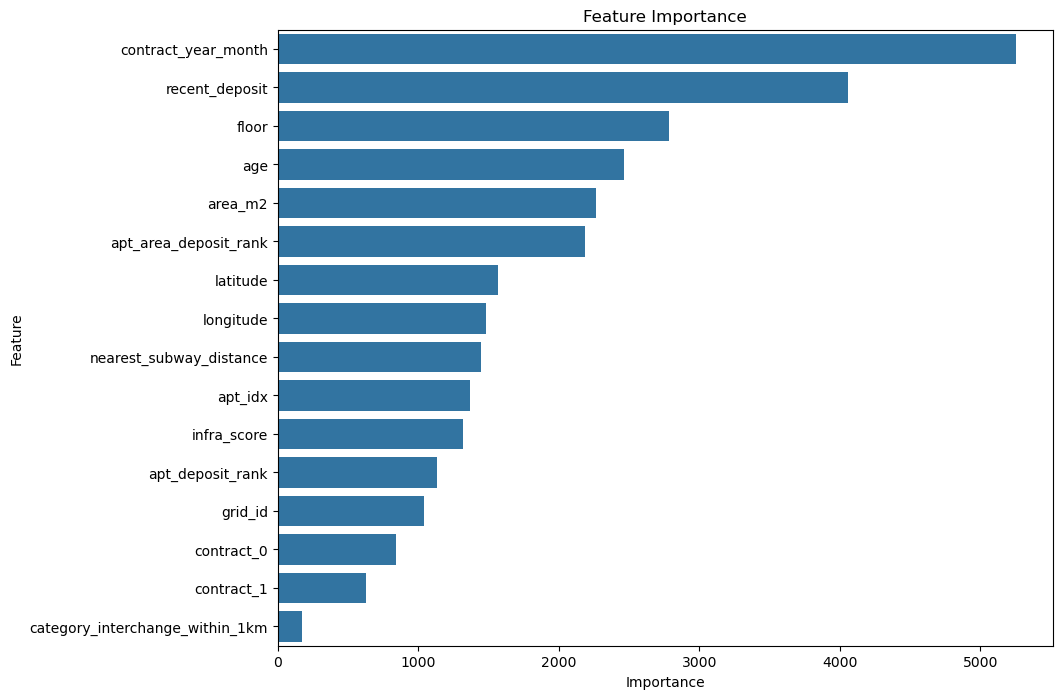

In [8]:
# LightGBM 모델의 피처 중요도 추출
feature_importance = model.feature_importance()

# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [12]:
y_pred

array([21919.87668855,  7329.86279029,  5780.38122069, ...,
       44851.04894911, 37350.23017771, 37413.53821842])

In [13]:
# Create a DataFrame from y_pred with the same index as X_test
y_pred_df = pd.DataFrame(y_pred, index=range(len(y_pred)), columns=['deposit'])

# Display the DataFrame
y_pred_df.index.name = 'index'
y_pred_df

,deposit
index,
0,21919.876689
1,7329.862790
2,5780.381221
3,5633.468105
4,5838.863354
...,...
150167,36896.657234
150168,43797.768798
150169,44851.048949


In [14]:
y_pred_df['deposit'].mean()

np.float64(39065.37303195744)

In [15]:
y_pred_df.to_csv(os.path.join(submission_path, "V7_lightGBM_Kfold5.csv"), index=True)